In [21]:
import pandas as pd
import numpy as np
import random
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

PARTITION_DIR = 's3://customer-churn-spark'

LEAD_TIMES = [0, 1, 2, 3, 4, 5, 6]

def retrieve_data(partition_num, label_type='MS-31', lead_periods=[1, 2, 3, 4, 5, 6]):
    """Retrieve features and labels and merge"""
    
    # Read in features and labels
    fm = pd.read_csv(f'{PARTITION_DIR}/p{partition_num}/{label_type}_feature_matrix.csv', low_memory=False).\
            drop(columns = ['label', 'days_to_churn', 'churn_date']).rename(columns = {'time': 'cutoff_time'})
    labels = pd.read_csv(f'{PARTITION_DIR}/p{partition_num}/{label_type}_labels.csv', low_memory=False)
    
    # Shift periods
    for period in lead_periods:
        labels[f'cutoff_time-{period}-label'] = labels.groupby('msno')['label'].shift(-1 * period)
    
    # Merge together features and labels
    feature_matrix = fm.merge(labels, on = ['msno', 'cutoff_time'], how = 'inner')
    return feature_matrix

In [9]:
pd.options.display.max_columns = 260

In [2]:
import random
random.seed(50)

from multiprocessing import Pool
pool = Pool(6)

# Set number of train and testing feature matrices
fms_to_get = 50

# Choose random sample of partitions
ps = random.sample(list(range(900)), fms_to_get)

# Retrieve feature matrices from S3
fms = []
for i, r in enumerate(pool.imap_unordered(retrieve_data, ps)):
    print(f'{round(100 * (i / fms_to_get), 2)}% complete.', end='\r')
    if r.shape[1] == 253:
        fms.append(r)
pool.close()
pool.join()

# Join together and drop rows with unknown label
feature_matrix = pd.concat(fms)
feature_matrix = feature_matrix[~feature_matrix['label'].isna()]

# Drop rows with no previous transactions
feature_matrix = feature_matrix[~feature_matrix['TIME_SINCE_LAST(transactions.transaction_date)'].isna()]

# Remove outliers
feature_matrix = feature_matrix[feature_matrix['TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, transaction_date)'] < 10]
feature_matrix.shape

(756530, 253)

In [19]:
fm = retrieve_data(531)

In [20]:
fm.sort_values(['msno', 'cutoff_time']).head()

,msno,cutoff_time,city,bd,registered_via,gender,SUM(transactions.payment_plan_days),SUM(transactions.plan_list_price),SUM(transactions.actual_amount_paid),SUM(transactions.price_difference),SUM(transactions.planned_daily_price),SUM(transactions.daily_price),TIME_SINCE_LAST(transactions.transaction_date),AVG_TIME_BETWEEN(transactions.transaction_date),ALL(transactions.is_auto_renew),ALL(transactions.is_cancel),MODE(transactions.payment_method_id),NUM_UNIQUE(transactions.payment_method_id),MIN(transactions.payment_plan_days),MIN(transactions.plan_list_price),MIN(transactions.actual_amount_paid),MIN(transactions.price_difference),MIN(transactions.planned_daily_price),MIN(transactions.daily_price),LAST(transactions.payment_plan_days),LAST(transactions.plan_list_price),LAST(transactions.actual_amount_paid),LAST(transactions.price_difference),LAST(transactions.planned_daily_price),LAST(transactions.daily_price),LAST(transactions.payment_method_id),LAST(transactions.is_auto_renew),LAST(transactions.is_cancel),MEAN(transactions.payment_plan_days),MEAN(transactions.plan_list_price),MEAN(transactions.actual_amount_paid),MEAN(transactions.price_difference),MEAN(transactions.planned_daily_price),MEAN(transactions.daily_price),PERCENT_TRUE(transactions.is_auto_renew),PERCENT_TRUE(transactions.is_cancel),MAX(transactions.payment_plan_days),MAX(transactions.plan_list_price),MAX(transactions.actual_amount_paid),MAX(transactions.price_difference),MAX(transactions.planned_daily_price),MAX(transactions.daily_price),STD(transactions.payment_plan_days),STD(transactions.plan_list_price),STD(transactions.actual_amount_paid),STD(transactions.price_difference),STD(transactions.planned_daily_price),STD(transactions.daily_price),COUNT(transactions),"TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)","TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, transaction_date)","TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, membership_expire_date)","TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, transaction_date)","TOTAL_PREVIOUS_MONTH(transactions.plan_list_price, membership_expire_date)","TOTAL_PREVIOUS_MONTH(transactions.daily_price, membership_expire_date)","TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, membership_expire_date)","TOTAL_PREVIOUS_MONTH(transactions.daily_price, transaction_date)","TOTAL_PREVIOUS_MONTH(transactions.price_difference, transaction_date)","TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, membership_expire_date)","TOTAL_PREVIOUS_MONTH(transactions.plan_list_price, transaction_date)","TOTAL_PREVIOUS_MONTH(transactions.price_difference, membership_expire_date)",SUM(logs.num_25),SUM(logs.num_50),SUM(logs.num_75),SUM(logs.num_985),SUM(logs.num_100),SUM(logs.num_unq),SUM(logs.total_secs),SUM(logs.total),SUM(logs.percent_100),SUM(logs.percent_unique),TIME_SINCE_LAST(logs.date),AVG_TIME_BETWEEN(logs.date),MIN(logs.num_25),MIN(logs.num_50),MIN(logs.num_75),MIN(logs.num_985),MIN(logs.num_100),MIN(logs.num_unq),MIN(logs.total_secs),MIN(logs.total),MIN(logs.percent_100),MIN(logs.percent_unique),LAST(logs.num_25),LAST(logs.num_50),LAST(logs.num_75),LAST(logs.num_985),LAST(logs.num_100),LAST(logs.num_unq),LAST(logs.total_secs),LAST(logs.total),LAST(logs.percent_100),LAST(logs.percent_unique),MEAN(logs.num_25),MEAN(logs.num_50),MEAN(logs.num_75),MEAN(logs.num_985),MEAN(logs.num_100),MEAN(logs.num_unq),MEAN(logs.total_secs),MEAN(logs.total),MEAN(logs.percent_100),MEAN(logs.percent_unique),MAX(logs.num_25),MAX(logs.num_50),MAX(logs.num_75),MAX(logs.num_985),MAX(logs.num_100),MAX(logs.num_unq),MAX(logs.total_secs),MAX(logs.total),MAX(logs.percent_100),MAX(logs.percent_unique),STD(logs.num_25),STD(logs.num_50),STD(logs.num_75),STD(logs.num_985),STD(logs.num_100),STD(logs.num_unq),STD(logs.total_secs),STD(logs.total),STD(logs.percent_100),STD(logs.percent_unique),COUNT(logs),"TOTAL_PREVIOUS_MONTH(logs.percent_unique, date)","TOTAL_PREVIOUS_MONTH(logs.total_secs, date)","TOTAL_PREVIOUS_MONTH(logs.num_

In [54]:
def train_test_data(fms_to_get=50, split_date=pd.datetime(2016, 6, 1)):

    # Choose random sample of partitions
    ps = random.sample(list(range(900)), fms_to_get)

    pool = Pool(6)
    # Retrieve feature matrices from S3
    fms = []
    for i, r in enumerate(pool.imap_unordered(retrieve_data, ps)):
        print(f'{round(100 * (i / fms_to_get), 2)}% complete.', end='\r')
        if r.shape[1] == 259:
            fms.append(r)
    pool.close()
    pool.join()

    # Join together and drop rows with unknown label
    feature_matrix = pd.concat(fms)
    
    # Drop rows with no previous transactions
    feature_matrix = feature_matrix[~feature_matrix['TIME_SINCE_LAST(transactions.transaction_date)'].isna()]
    # Remove outliers
    feature_matrix = feature_matrix[feature_matrix['TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, transaction_date)'] < 10]
    feature_matrix.drop(columns = [c for c in ['churn', 'days_to_next_churn', 
                                               'churn_date'] if c in feature_matrix],
                        inplace = True)
    print(f'Original feature matrix shape: {feature_matrix.shape}')

    # Convert boolean columns
    feature_matrix = feature_matrix.replace({'False': 0, 'True': 1}).rename(columns = {'label': 'cutoff_time-0-label'})
    bool_cols = [c for c in feature_matrix if 'ALL' in c or ('WEEKEND' in c and 'PERCENT_TRUE' not in c)]
    for c in bool_cols:
        feature_matrix[c] = feature_matrix[c].astype(float)
    
    # Missing values
    threshold = 0.9
    missing_pct = feature_matrix.isnull().sum() / len(feature_matrix)
    to_drop = list((missing_pct[missing_pct > threshold]).index)
    to_drop = [x for x in to_drop if x != 'days_to_churn']
    print(f'There are {len(to_drop)} columns to drop with more than {threshold} missing values.')
    feature_matrix.drop(columns = to_drop, inplace = True)
    
    # One unique value
    one_unique = feature_matrix.apply(lambda x: x.nunique() == 1, axis = 0)
    print(f'There are {len(to_drop)} columns to drop with one unique value.')
    to_drop = list(one_unique[one_unique == True].index)
    feature_matrix.drop(columns = to_drop, inplace = True)

    # Collinear features
    threshold = 0.95
    # Calculate correlations
    corr_matrix = feature_matrix.corr().abs()
    # Subset to the upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Identify names of columns with correlation above threshold
    to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]
    print(f'There are {len(to_drop)} columns to drop with correlation > {threshold}.')
    feature_matrix.drop(columns = to_drop, inplace = True)
    
    # Split into training and testing
    feature_matrix['cutoff_time'] = pd.to_datetime(feature_matrix['cutoff_time'])
    feature_matrix.sort_values(['msno', 'cutoff_time'], inplace = True)
    test = feature_matrix[feature_matrix['cutoff_time'] >= split_date].copy()
    train = feature_matrix[feature_matrix['cutoff_time'] < split_date].copy()
    test_dates = test[[x for x in test if 'cutoff_time' in x]]
    train_dates = train[[x for x in train if 'cutoff_time' in x]]
    
    train = pd.get_dummies(train.drop(columns = ['msno'] + list(train_dates.columns)))
    test = pd.get_dummies(test.drop(columns = ['msno'] + list(test_dates.columns)))
    train, test = train.align(test, join = 'inner', axis = 1)
    
    # Extract labels
    # y, test_y = np.array(train.pop('label')), np.array(test.pop('label'))
    # y_reg, test_y_reg = np.array(train.pop('days_to_churn')), np.array(test.pop('days_to_churn'))
    
    # Fill in missing values
    train = train.replace({np.inf: np.nan, -np.inf: np.nan}).\
        fillna(train.median())
    test = test.replace({np.inf: np.nan, -np.inf: np.nan}).\
        fillna(train.median())
    
    train = pd.concat([train, train_dates], axis = 1)
    test = pd.concat([test, test_dates], axis = 1)

    return feature_matrix, train, test

In [55]:
fm, train, test = train_test_data()

Original feature matrix shape: (985185, 258)
There are 0 columns to drop with more than 0.9 missing values.
There are 0 columns to drop with one unique value.
There are 75 columns to drop with correlation > 0.95.


In [56]:
train.head()

,city,bd,registered_via,SUM(transactions.payment_plan_days),SUM(transactions.price_difference),SUM(transactions.planned_daily_price),TIME_SINCE_LAST(transactions.transaction_date),AVG_TIME_BETWEEN(transactions.transaction_date),ALL(transactions.is_auto_renew),ALL(transactions.is_cancel),MODE(transactions.payment_method_id),NUM_UNIQUE(transactions.payment_method_id),MIN(transactions.payment_plan_days),MIN(transactions.actual_amount_paid),MIN(transactions.price_difference),MIN(transactions.planned_daily_price),MIN(transactions.daily_price),LAST(transactions.payment_plan_days),LAST(transactions.price_difference),LAST(transactions.planned_daily_price),LAST(transactions.daily_price),LAST(transactions.payment_method_id),LAST(transactions.is_auto_renew),LAST(transactions.is_cancel),MEAN(transactions.price_difference),MEAN(transactions.planned_daily_price),MEAN(transactions.daily_price),PERCENT_TRUE(transactions.is_cancel),MAX(transactions.price_difference),MAX(transactions.planned_daily_price),MAX(transactions.daily_price),STD(transactions.payment_plan_days),STD(transactions.actual_amount_paid),STD(transactions.price_difference),STD(transactions.planned_daily_price),STD(transactions.daily_price),"TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)","TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, transaction_date)","TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, membership_expire_date)","TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, transaction_date)","TOTAL_PREVIOUS_MONTH(transactions.daily_price, membership_expire_date)","TOTAL_PREVIOUS_MONTH(transactions.price_difference, transaction_date)","TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, membership_expire_date)","TOTAL_PREVIOUS_MONTH(transactions.price_difference, membership_expire_date)",SUM(logs.num_25),SUM(logs.num_50),SUM(logs.num_75),SUM(logs.num_985),SUM(logs.num_100),SUM(logs.num_unq),SUM(logs.total_secs),SUM(logs.percent_100),SUM(logs.percent_unique),TIME_SINCE_LAST(logs.date),AVG_TIME_BETWEEN(logs.date),MIN(logs.num_25),MIN(logs.num_50),MIN(logs.num_75),MIN(logs.num_985),MIN(logs.num_100),MIN(logs.num_unq),MIN(logs.total_secs),MIN(logs.total),MIN(logs.percent_100),MIN(logs.percent_unique),LAST(logs.num_25),LAST(logs.num_50),LAST(logs.num_75),LAST(logs.num_985),LAST(logs.num_100),LAST(logs.num_unq),LAST(logs.total_secs),LAST(logs.total),LAST(logs.percent_100),LAST(logs.percent_unique),MEAN(logs.num_25),MEAN(logs.num_50),MEAN(logs.num_75),MEAN(logs.num_985),MEAN(logs.num_100),MEAN(logs.num_unq),MEAN(logs.total_secs),MEAN(logs.total),MEAN(logs.percent_100),MEAN(logs.percent_unique),MAX(logs.num_25),MAX(logs.num_50),MAX(logs.num_75),MAX(logs.num_985),MAX(logs.num_100),MAX(logs.num_unq),MAX(logs.total_secs),MAX(logs.total),MAX(logs.percent_100),MAX(logs.percent_unique),STD(logs.num_25),STD(logs.num_50),STD(logs.num_75),STD(logs.num_985),STD(logs.num_100),STD(logs.num_unq),STD(logs.total_secs),STD(logs.total),STD(logs.percent_100),STD(logs.percent_unique),"TOTAL_PREVIOUS_MONTH(logs.percent_unique, date)","TOTAL_PREVIOUS_MONTH(logs.total_secs, date)","TOTAL_PREVIOUS_MONTH(logs.num_unq, date)","TOTAL_PREVIOUS_MONTH(logs.num_100, date)","TOTAL_PREVIOUS_MONTH(logs.num_50, date)","TOTAL_PREVIOUS_MONTH(logs.num_25, date)","TOTAL_PREVIOUS_MONTH(logs.percent_100, date)","TOTAL_PREVIOUS_MONTH(logs.num_985, date)","TOTAL_PREVIOUS_MONTH(logs.num_75, date)",WEEKEND(registration_init_time),DAY(registration_init_time),MONTH(registration_init_time),SUM(transactions.payment_plan_days WHERE is_auto_renew = 0),SUM(transactions.payment_plan_days WHERE is_cancel = 1),SUM(transactions.payment_plan_days WHERE is_auto_renew = 1),SUM(transactions.actual_amount_paid WHERE is_cancel = 1),SUM(transactions.price_difference WHERE is_auto_renew = 0),SUM(transactions.price_difference WHERE is_cancel = 1),SUM(transactions.price_difference WHERE is_auto_renew = 1),SUM(transactions.planned_daily_price WHERE is_auto_renew = 0),ALL(transactions.is_cancel WHERE is_aut

In [88]:
def plot_precision_recall(test_y, probs, title = 'Precision Recall Curve', threshold_selected = None):
    """Plot a precision recall curve for predictions. 
       Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py"""
    
    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize = (10, 8))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size = 18)
    plt.ylabel('Precision', size = 18)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size = 20)
    plt.xticks(size = 14); plt.yticks(size = 14)
    
    if threshold_selected:
        p = precision(np.where(threshold == threshold_selected)[0])
        r = recall(np.where(threshold == threshold_selected)[0])
        plt.scatter(r, p, marker = '*', size = 200)
        plt.vlines(r, ymin = 0, ymax = p, linestyles = '--');
        plt.hlines(p, xmin = 0, xmax = r, linestyles = '--');
    plt.show()
    pr = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1],
                       'threshold': threshold})
    return pr


Lead time = 0 months
Number of Training Examples: 456215
Number of Testing Examples: 352957
Feature Importances
                                               feature  importance
36   TOTAL_PREVIOUS_MONTH(transactions.actual_amoun...    0.182177
37   TOTAL_PREVIOUS_MONTH(transactions.payment_plan...    0.127027
39   TOTAL_PREVIOUS_MONTH(transactions.planned_dail...    0.113255
38   TOTAL_PREVIOUS_MONTH(transactions.payment_plan...    0.024337
141           LAST(transactions.DAY(transaction_date))    0.022862
7      AVG_TIME_BETWEEN(transactions.transaction_date)    0.020670
40   TOTAL_PREVIOUS_MONTH(transactions.daily_price,...    0.019846
21                LAST(transactions.payment_method_id)    0.019616
42   TOTAL_PREVIOUS_MONTH(transactions.actual_amoun...    0.018950
23                        LAST(transactions.is_cancel)    0.018922

ROC AUC: 0.9886
precision_score: 0.3319
recall_score: 0.9837
f1_score: 0.4963


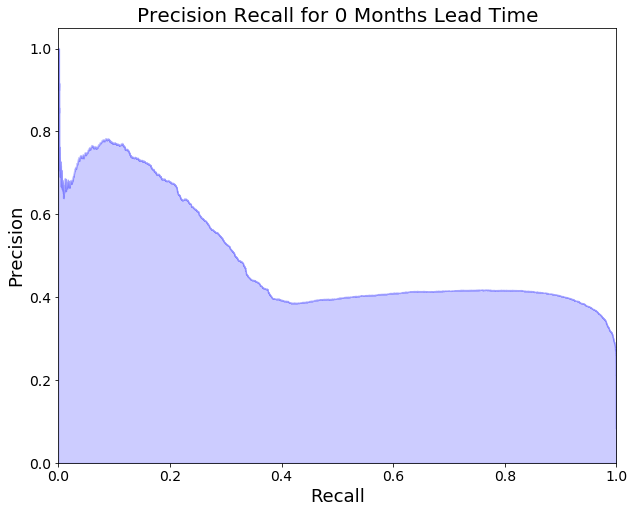


Lead time = 1 months
Number of Training Examples: 447545
Number of Testing Examples: 308803
Feature Importances
                                               feature  importance
36   TOTAL_PREVIOUS_MONTH(transactions.actual_amoun...    0.060867
7      AVG_TIME_BETWEEN(transactions.transaction_date)    0.036573
37   TOTAL_PREVIOUS_MONTH(transactions.payment_plan...    0.036145
141           LAST(transactions.DAY(transaction_date))    0.036072
10                MODE(transactions.payment_method_id)    0.030603
119  SUM(transactions.payment_plan_days WHERE is_au...    0.027890
21                LAST(transactions.payment_method_id)    0.026705
124  SUM(transactions.planned_daily_price WHERE is_...    0.024521
6       TIME_SINCE_LAST(transactions.transaction_date)    0.024409
38   TOTAL_PREVIOUS_MONTH(transactions.payment_plan...    0.023616

ROC AUC: 0.9014
precision_score: 0.0975
recall_score: 0.6735
f1_score: 0.1703


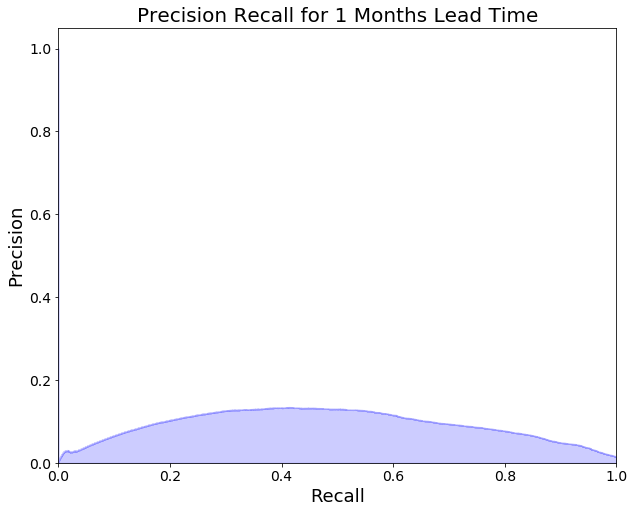


Lead time = 2 months
Number of Training Examples: 440899
Number of Testing Examples: 262841
Feature Importances
                                               feature  importance
141           LAST(transactions.DAY(transaction_date))    0.049656
6       TIME_SINCE_LAST(transactions.transaction_date)    0.042395
21                LAST(transactions.payment_method_id)    0.040032
7      AVG_TIME_BETWEEN(transactions.transaction_date)    0.039272
10                MODE(transactions.payment_method_id)    0.031517
132           MODE(transactions.DAY(transaction_date))    0.028035
25              MEAN(transactions.planned_daily_price)    0.025968
143         LAST(transactions.MONTH(transaction_date))    0.024804
124  SUM(transactions.planned_daily_price WHERE is_...    0.022837
136     NUM_UNIQUE(transactions.DAY(transaction_date))    0.022363

ROC AUC: 0.8982
precision_score: 0.1081
recall_score: 0.6149
f1_score: 0.1838


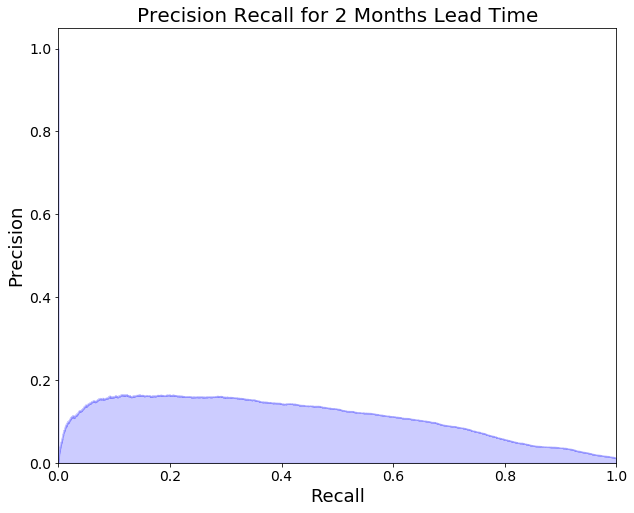


Lead time = 3 months
Number of Training Examples: 432776
Number of Testing Examples: 218721
Feature Importances
                                               feature  importance
136     NUM_UNIQUE(transactions.DAY(transaction_date))    0.042264
141           LAST(transactions.DAY(transaction_date))    0.041615
143         LAST(transactions.MONTH(transaction_date))    0.037919
21                LAST(transactions.payment_method_id)    0.030614
10                MODE(transactions.payment_method_id)    0.029834
144   LAST(transactions.MONTH(membership_expire_date))    0.029339
117  SUM(transactions.payment_plan_days WHERE is_au...    0.028551
148  MEAN(transactions.plan_list_price WHERE is_aut...    0.026764
8                      ALL(transactions.is_auto_renew)    0.026019
146  MEAN(transactions.payment_plan_days WHERE is_a...    0.025304

ROC AUC: 0.9017
precision_score: 0.0934
recall_score: 0.5781
f1_score: 0.1609


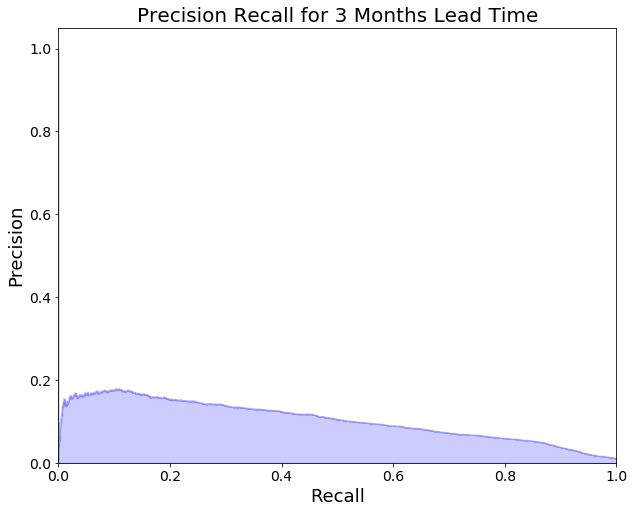


Lead time = 4 months
Number of Training Examples: 424705
Number of Testing Examples: 176823
Feature Importances
                                               feature  importance
141           LAST(transactions.DAY(transaction_date))    0.066638
21                LAST(transactions.payment_method_id)    0.039080
10                MODE(transactions.payment_method_id)    0.033218
124  SUM(transactions.planned_daily_price WHERE is_...    0.032803
148  MEAN(transactions.plan_list_price WHERE is_aut...    0.030870
146  MEAN(transactions.payment_plan_days WHERE is_a...    0.030795
144   LAST(transactions.MONTH(membership_expire_date))    0.029695
136     NUM_UNIQUE(transactions.DAY(transaction_date))    0.029252
6       TIME_SINCE_LAST(transactions.transaction_date)    0.024587
143         LAST(transactions.MONTH(transaction_date))    0.024539

ROC AUC: 0.9126
precision_score: 0.0957
recall_score: 0.5830
f1_score: 0.1644


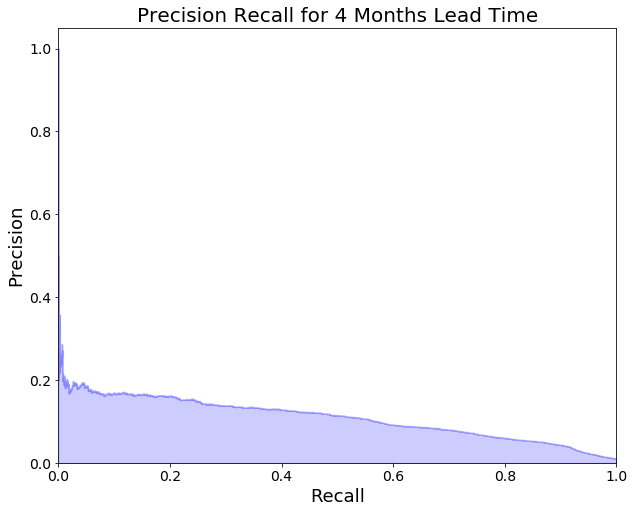


Lead time = 5 months
Number of Training Examples: 416552
Number of Testing Examples: 136700
Feature Importances
                                               feature  importance
36   TOTAL_PREVIOUS_MONTH(transactions.actual_amoun...    0.036804
124  SUM(transactions.planned_daily_price WHERE is_...    0.035902
10                MODE(transactions.payment_method_id)    0.031896
21                LAST(transactions.payment_method_id)    0.031711
141           LAST(transactions.DAY(transaction_date))    0.031362
144   LAST(transactions.MONTH(membership_expire_date))    0.027754
146  MEAN(transactions.payment_plan_days WHERE is_a...    0.027662
136     NUM_UNIQUE(transactions.DAY(transaction_date))    0.026622
143         LAST(transactions.MONTH(transaction_date))    0.025227
148  MEAN(transactions.plan_list_price WHERE is_aut...    0.024936

ROC AUC: 0.917
precision_score: 0.0823
recall_score: 0.5785
f1_score: 0.1441


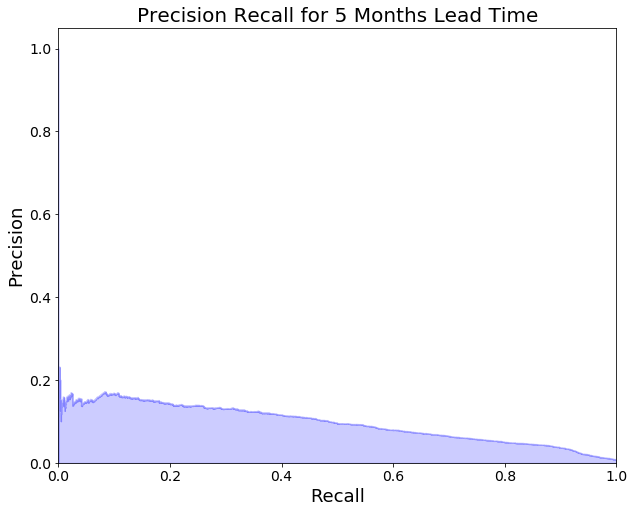


Lead time = 6 months
Number of Training Examples: 407901
Number of Testing Examples: 98932
Feature Importances
                                               feature  importance
21                LAST(transactions.payment_method_id)    0.039421
136     NUM_UNIQUE(transactions.DAY(transaction_date))    0.038692
10                MODE(transactions.payment_method_id)    0.034118
124  SUM(transactions.planned_daily_price WHERE is_...    0.032709
144   LAST(transactions.MONTH(membership_expire_date))    0.031038
146  MEAN(transactions.payment_plan_days WHERE is_a...    0.030566
148  MEAN(transactions.plan_list_price WHERE is_aut...    0.025922
141           LAST(transactions.DAY(transaction_date))    0.023593
6       TIME_SINCE_LAST(transactions.transaction_date)    0.022967
167                             LAST(logs.MONTH(date))    0.022839

ROC AUC: 0.911
precision_score: 0.0765
recall_score: 0.5150
f1_score: 0.1332


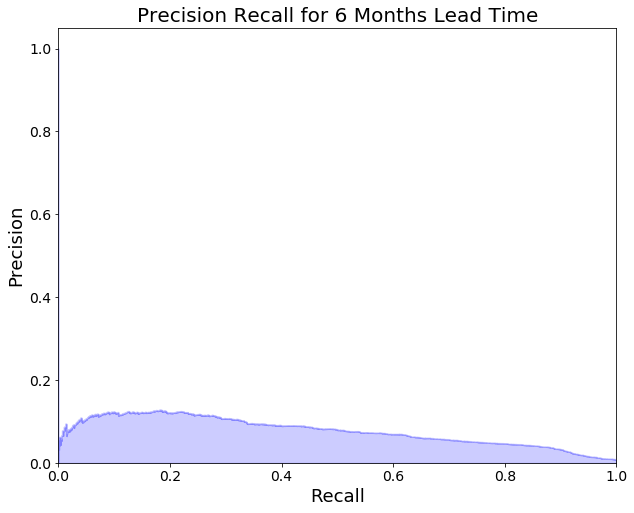

In [108]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

def evaluate_lead_times(model, train, test, lead_times = [0, 1, 2, 3, 4, 5, 6]):
    """Evaluate a machine learning model on four metrics:
       ROC AUC, precision score, recall score, and f1 score.
       
       Returns the model and the predictions."""
    
    original_train = train.copy()
    original_test = test.copy()
    to_drop = [x for x in train if 'cutoff_time' in x] + ['days_to_churn']

    metrics = []
    metric_names = []
    
    for i in lead_times:
        
        train = original_train[~original_train[f'cutoff_time-{i}-label'].isna()].copy()
        test = original_test[~original_test[f'cutoff_time-{i}-label'].isna()].copy()
        
        print(f'\nLead time = {i} months')
        print(f'Number of Training Examples: {len(train)}')
        print(f'Number of Testing Examples: {len(test)}')
        
        y = np.array(train[f'cutoff_time-{i}-label'])
        test_y = np.array(test[f'cutoff_time-{i}-label'])
        
        model.fit(train.drop(columns = to_drop), y)
        print('Feature Importances')
        fi = pd.DataFrame({'feature': list(train.drop(columns = to_drop).columns),
                           'importance': model.feature_importances_}).sort_values('importance', ascending = False)
        print(fi.head(10))
        
        # Predict probabilities and labels
        probs = model.predict_proba(test.drop(columns = to_drop))[:, 1]
        preds = model.predict(test.drop(columns = to_drop))

        # Calculate ROC AUC
        roc = roc_auc_score(test_y, probs)
        metrics.append(roc)
        metric_names.append('roc')

        print(f'\nROC AUC: {round(roc, 4)}')

        # Iterate through metrics
        for metric in [precision_score, recall_score, f1_score]:
            value = metric(test_y, preds)
            name = metric.__name__
            metrics.append(value)
            metric_names.append(name)
            
            # Use .__name__ attribute to list metric
            print(f'{name}: {value:.4f}')
        
        _ = plot_precision_recall(test_y, probs, title = f'Precision Recall for {i} Months Lead Time')
    
    results = pd.DataFrame({'value': metrics, 'metric': metric_names, 'lead_time': list(np.repeat(lead_times, 4))})
    return model, results

model = RandomForestClassifier(n_estimators=100, max_depth=40,
                               min_samples_leaf=50,
                               n_jobs=-1, class_weight='balanced',
                               random_state=50)
model, results = evaluate_lead_times(model, train, test)

In [104]:
x = pd.DataFrame({'a': [np.nan, 1, 0], 'b': [np.nan, 1, 1]})
x.nunique()

a    2
b    1
dtype: int64

In [107]:
x.apply(lambda x: len(x.unique()))

a    3
b    2
dtype: int64

In [97]:
%%timeit
x.apply(lambda x: len(x.unique()) == 1)

616 µs ± 4.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [98]:
%%timeit
x.apply(lambda x: x.nunique() == 1)

670 µs ± 3.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


a    2
b    1
dtype: int64

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

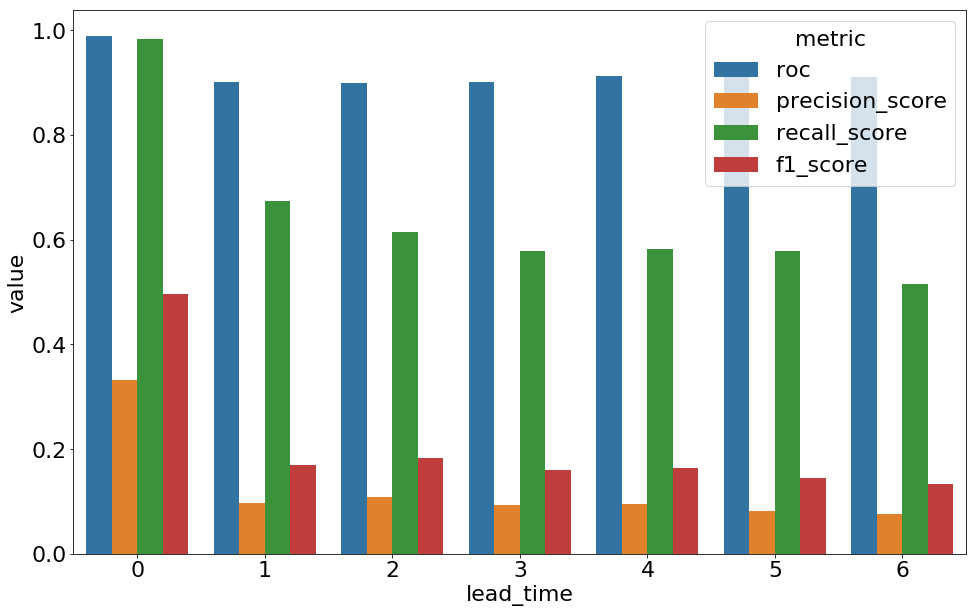

In [109]:
plt.figure(figsize = (16, 10))
plt.rcParams['font.size'] = 22
sns.barplot(x = 'lead_time', y = 'value', hue = 'metric', data = results);

In [60]:
model.feature_importances_.shape

(171,)

In [62]:
to_drop = [x for x in train if 'cutoff_time' in x] + ['days_to_churn']
n = train.drop(columns = to_drop)
n.shape

(543115, 171)

In [64]:
pd.DataFrame({'feature': list(n.columns), 'importance': model.feature_importances_}).sort_values('importance').head()

,feature,importance
9,ALL(transactions.is_cancel),0.000036
57,MIN(logs.num_75),0.000044
160,ALL(logs.WEEKEND(date)),0.000049
149,MEAN(transactions.actual_amount_paid WHERE is_...,0.000054
58,MIN(logs.num_985),0.000056


In [66]:
original_train = train.copy()
original_test = test.copy()

In [67]:
i = 2
new_train = original_train[~original_train[f'cutoff_time-{i}-label'].isna()].copy()
new_test = original_test[~original_test[f'cutoff_time-{i}-label'].isna()].copy()

In [70]:
y = np.array(new_train[f'cutoff_time-{i}-label'])
y.mean()

0.03639835880779952

In [68]:
y_test = np.array(new_test[f'cutoff_time-{i}-label'])
y_test.mean()

0.011063722935158518

In [69]:
roc_auc_score(y_test, np.repeat(y_test.mean(), len(y_test)))

0.5

In [74]:
to_drop = [x for x in train if 'cutoff_time' in x] + ['days_to_churn']
model.fit(new_train.drop(columns = to_drop), y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [76]:
preds = model.predict(new_test.drop(columns = to_drop))
np.mean(preds == y_test)

0.9869236534635007

In [77]:
preds

array([0., 0., 0., ..., 0., 0., 0.])

In [80]:
probas =  model.predict_proba(new_test.drop(columns = to_drop))[:, 1]

In [81]:
roc_auc_score(y_test, probas)

0.8400858757958107

,precision,recall,threshold
0,0.011064,1.000000,0.000000
1,0.017352,0.941541,0.008687
2,0.017354,0.941541,0.008982
3,0.017354,0.941541,0.009298
4,0.017356,0.941541,0.009636
5,0.017365,0.941541,0.009754
6,0.017365,0.941541,0.009815
7,0.017374,0.941541,0.009876
8,0.017377,0.941541,0.009906
9,0.017378,0.941541,0.009937


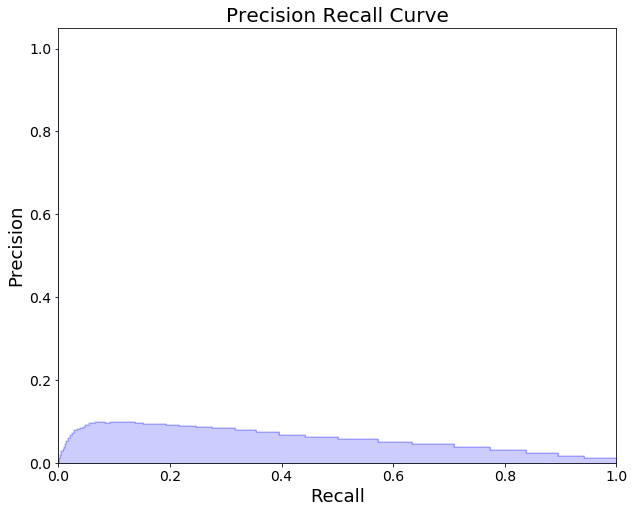

In [86]:
plot_precision_recall(y_test, probas)